In [1]:
using Pkg
Pkg.activate("climate"; shared=true)

"/Users/imolk/Library/Julia/environments/climate/Project.toml"

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [3]:
using PyCall
using Printf
@pyimport mpl_toolkits.basemap as basemap
;

In [4]:
import Shapefile
import GeoInterface
import LibGEOS
import Proj4
import CSV
using DataFrames: head, nrow

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1185


In [5]:
using TempModel
;

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1185


# Finding nearby stations

In [6]:
data_dir = "../data"
epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)
@show nrow(isdList), nrow(isd_wData)

itest = rand(1:nrow(isd_wData))
test_station = isd_wData[itest,:]
k_nearest = 5
nearest_and_test = TempModel.find_nearest(isd_wData, 
        test_station[1, :USAF], test_station[1, :WBAN], 
        k_nearest)

(nrow(isdList), nrow(isd_wData)) = (4256, 315)


,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Float64,Float64
1,724088,13707,DOVER AFB AIRPORT,US,DE,KDOV,39.133,-75.467,8.5,1942,2015,-8.40095e6,4.74074e6
2,724075,13735,MILLVILLE MUNICIPAL ARPT,US,NJ,KMIV,39.367,-75.067,21.3,1973,2015,-8.35642e6,4.77438e6
3,724080,13739,PHILADELPHIA INTERNATIONAL AIRPORT,US,PA,KPHL,39.868,-75.231,3.1,1973,2015,-8.37468e6,4.84678e6
4,724070,93730,ATLANTIC CITY INTERNATIONAL AIRPORT,US,NJ,KACY,39.449,-74.567,18.3,1947,2015,-8.30076e6,4.78619e6
5,724060,93721,BALTIMORE-WASHINGTON INTL AIRPORT,US,MD,KBWI,39.167,-76.683,47.6,1945,2015,-8.53631e6,4.74562e6
6,724096,14706,MCGUIRE AFB AIRPORT,US,NJ,KWRI,40.017,-74.6,39.9,1942,2015,-8.30443e6,4.86841e6


In [9]:
ICAO = "KCEF"
test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
nrow(test_station)

1

In [13]:
function plot_map(isdSubset, epsg::Int; first_test::Bool=false, arcgis::Bool=false, resolution="i")
    minlon = minimum(isdSubset[:LON])
    maxlon = maximum(isdSubset[:LON])
    minlat = minimum(isdSubset[:LAT])
    maxlat = maximum(isdSubset[:LAT])
    
    # add a bit of padding
    pad = 0.1
    llcrnrlon = minlon - pad*(maxlon-minlon)
    llcrnrlat = minlat - pad*(maxlat-minlat)
    urcrnrlon = maxlon + pad*(maxlon-minlon)
    urcrnrlat = maxlat + pad*(maxlat-minlat)
    @show llcrnrlon, urcrnrlon
    @show llcrnrlat, urcrnrlat
    @show resolution

    map = basemap.Basemap(epsg=epsg, 
                          llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
                          resolution=resolution, suppress_ticks=false)
    if arcgis
        map[:arcgisimage](service="World_Shaded_Relief", xpixels = 1500, verbose=true, zorder=1, dpi=100)
    end
    map[:drawstates](linewidth=1.0, zorder=2, color=cbbPalette[1])
    
    llcrnrx, urcrnrx = map[:llcrnrx], map[:urcrnrx]
    width = urcrnrx - llcrnrx
    @show llcrnrx, urcrnrx

    x_0 = map[:projparams]["x_0"]
    y_0 = map[:projparams]["y_0"]
    @show x_0, y_0
    _xlim = plt.xlim()
    _ylim = plt.ylim()
    
    for i in 1:nrow(isdSubset)
        lat, lon = isdSubset[i, :LAT], isdSubset[i, :LON]

        x, y = map(lon, lat)
        if !ismissing(isdSubset[i, :ICAO])
            label = isdSubset[i, :ICAO]
        else
            label = @sprintf("%d", isdSubset[i, :USAF])
        end
        if i == 1 && first_test
            plt.plot(x, y, "o", color=cbbPalette[6], zorder=4)
        else
            plt.plot(x, y, "x", color="black", zorder=4)
        end
        if lon > (llcrnrlon+urcrnrlon)/2
            # align right
            plt.annotate(label, xy=(x, y),  xycoords="data",
                            xytext=(-5, 5), textcoords="offset points",
                            fontsize=8,
                            color="black",
                            horizontalalignment="right",
                            zorder=3
                            )
        else
            plt.annotate(label, xy=(x, y),  xycoords="data",
                            xytext=(5, 5), textcoords="offset points",
                            fontsize=8,
                            color="black",
                            horizontalalignment="left",
                            zorder=3
                            )
        end
    end

    # assumes EPSG unit is meters
    _xticks = plt.xticks()[1]
    plt.xticks(_xticks, [@sprintf("%.0f", x/1000) for x in _xticks])
    _yticks = plt.yticks()[1]
    plt.yticks(_yticks, [@sprintf("%.0f", x/1000) for x in _yticks])
    plt.xlabel("Eastings (km)")
    plt.ylabel("Northings (km)")
    plt.xlim(_xlim)
    plt.ylim(_ylim)
    plt.text(0.99, 0.01, "Esri, HERE, Garmin, FAO, NOAA | Copyright: 2014 Esri",
        horizontalalignment="right",
        verticalalignment="bottom",
        fontsize=5,
        bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
        transform = plt.gca()[:transAxes],)
end
;

(llcrnrlon, urcrnrlon) = (-118.15539999999999, -117.09460000000001)
(llcrnrlat, urcrnrlat) = (32.5174, 35.1166)
resolution = "i"
(llcrnrx, urcrnrx) = 

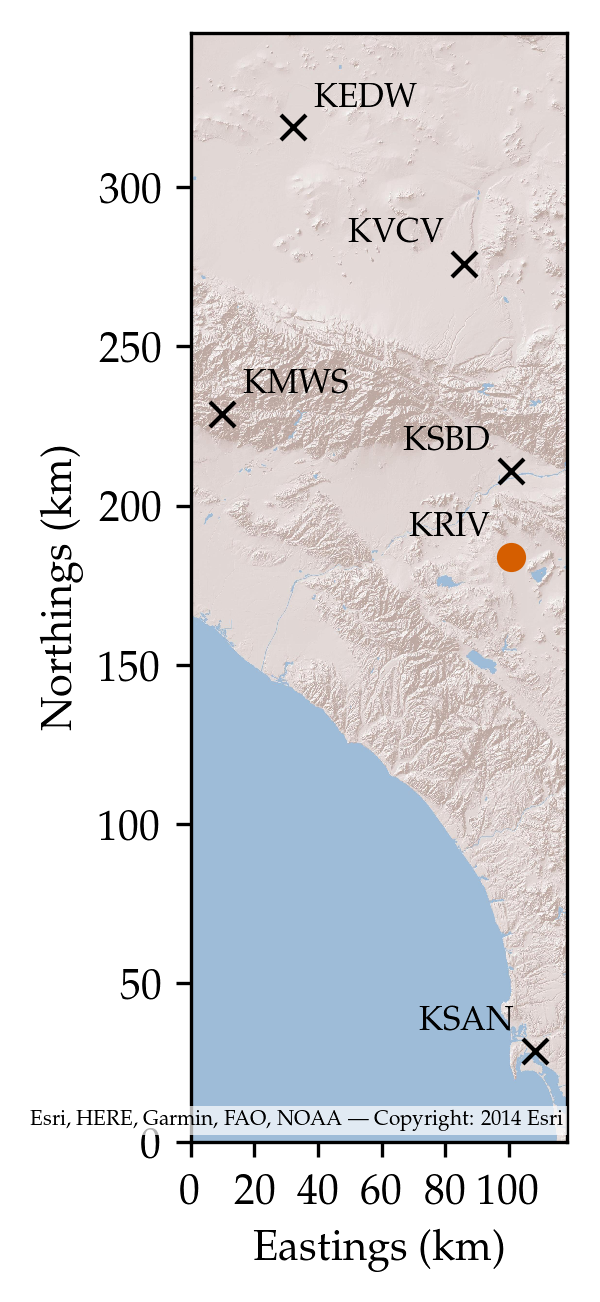

(0.0, 118087.71583350148)
(x_0, y_0) = (-0.0, -3.8314206904945853e6)


In [16]:
plot_map(nearest_and_test, epsg; arcgis=true, first_test=true)
;

# Centroid of each state

In [9]:
wgs84 = Proj4.Projection("+proj=longlat +datum=WGS84 +no_defs")
epsg3857 = Proj4.Projection(Proj4.epsg[:3857])
minlon = minimum(isd_wData[:LON])
maxlon = maximum(isd_wData[:LON])
minlat = minimum(isd_wData[:LAT])
maxlat = maximum(isd_wData[:LAT])

path = joinpath(data_dir,"cb_2017_us_state_5m","cb_2017_us_state_5m.shp")
handle = open(path, "r") do io
    read(io, Shapefile.Handle)
end

inearcentroids = Int64[]
for stateshape in handle.shapes
    poly = LibGEOS.MultiPolygon(GeoInterface.coordinates(stateshape))
    centroid_lonlat = GeoInterface.coordinates(LibGEOS.centroid(poly))
    if !(minlat < centroid_lonlat[2] < maxlat)
        continue
    elseif !(minlon < centroid_lonlat[1] < maxlon)
        continue
    end
    centroid = Proj4.transform(wgs84, epsg3857, centroid_lonlat)
    distances = sqrt.((isd_wData[:X_PRJ].-centroid[1]).^2+(isd_wData[:Y_PRJ].-centroid[2]).^2)
    inearest = argmin(distances)
    nearest_station = isd_wData[inearest,:]
    
    state = nearest_station[1, :STATE]
    airport = nearest_station[1, :ICAO]
    push!(inearcentroids, inearest)
end
sort!(inearcentroids)
;

In [10]:
# plot_map(isd_wData[inearcentroids, :], epsg; arcgis=false, resolution="l")
# ;

In [11]:
test_stations = isd_wData[inearcentroids, [:STATE, :USAF, :WBAN, :ICAO]]
head(test_stations)

,STATE,USAF,WBAN,ICAO
,String⍰,Int64⍰,Int64⍰,String⍰
1,GA,722175,13860,KWRB
2,AL,722265,13821,KMXF
3,MS,722350,3940,KJAN
4,LA,722487,13935,KESF
5,TX,722630,23034,KSJT
6,AZ,722780,23183,KPHX


In [12]:
CSV.write(joinpath(data_dir, "test_stations.csv"), test_stations)
;